In [75]:
import rebound
import numpy as np

In [76]:
'''Set-Up Initial Conditions'''
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    smass = 1.0 #in Solar Mass units
    jmass = 0.000954588 #Jupiter Mass in Solar Mass units
    delta_critical = 2.40*(np.cbrt(2.0*jmass))
    sim.add(m = smass)
    sim.add(m = jmass, a= 1, r = (0.000477895/6), f = 0, hash="planet1")
    sim.add(m = jmass, a= ((1 + delta_critical))-0.0115, r = (0.000477895/6), f = np.pi, hash="planet2")
    sim.move_to_com()
    return sim

In [77]:
jmass = 0.000954588 #Jupiter Mass in Solar Mass units
delta_critical = 2.40*(np.cbrt(2.0*jmass))
print((0.3*(1 + delta_critical)))
print((0.3*(1 + delta_critical))-0.0015)

0.38931981574769764
0.38781981574769764


Protoplanet 1 Semi-Major Axis: 1.0 AU
Protoplanet 2 Semi-Major Axis: 1.2862327191589922 AU
Period of Protoplanet 1: 0.9995419250229012 yr
Period of Protoplanet 2: 1.4573818434820123 yr
True Anomaly of Protoplanet 1: 0.0 radians
True Anomaly of Protoplanet 2: 0.0 radians


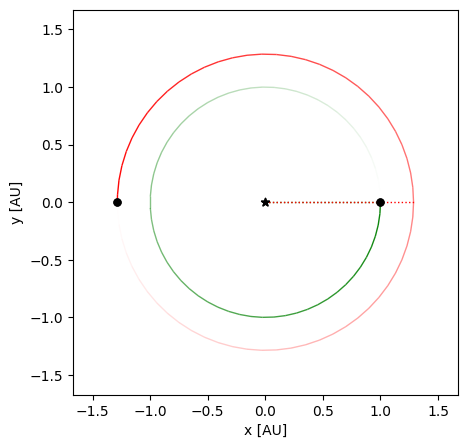

In [78]:
'''Conditions before collision'''
sim = setupSimulation()
tmax = 1e4

period1 = np.array([i.P for i in sim.calculate_orbits()])
omega1 = np.array([i.omega for i in sim.calculate_orbits()])
ecc = np.array([i.e for i in sim.calculate_orbits()])
p1 = period1[0]
p2 = period1[1]
f1 = omega1[0]
f2 = omega1[1]

print(f"Protoplanet 1 Semi-Major Axis: {sim.calculate_orbits()[0].a} AU")
print(f"Protoplanet 2 Semi-Major Axis: {sim.calculate_orbits()[1].a} AU")
print(f'Period of Protoplanet 1: {p1} yr')
print(f'Period of Protoplanet 2: {p2} yr')
print(f"True Anomaly of Protoplanet 1: {f1} radians")
print(f"True Anomaly of Protoplanet 2: {f2} radians")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [79]:
'''Collision Resolve Function to count the number of close encounters'''
def close_encounter(sim_pointer, collision):
    global count
    global temp
    sim = sim_pointer.contents
    temp = temp + 1
    count = np.append(count, temp)
    return 0

In [80]:
sim = setupSimulation()
temp = 0
count = np.array([0])
sim.collision = "direct"
sim.collision_resolve = close_encounter
sim.integrate(tmax)
print(f"Number of Close Encounters: {count}")

Number of Close Encounters: [     0      1      2 ... 152652 152653 152654]


In [81]:
def my_merge(sim_pointer, collided_particles_index):
    global simulation_time
    sim = sim_pointer.contents 
    ps = sim.particles 
    i = collided_particles_index.p1  
    j = collided_particles_index.p2 

    simulation_time = sim.t
    print(f"First Collision Occurs at time: {simulation_time} yr")
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass 
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   
    ps[i].m = total_mass    
    ps[i].r = merged_radius 
    
    return 2

In [82]:
'''Merge Condition'''
sim = setupSimulation()
sim.collision = 'direct'
sim.collision_resolve = my_merge
sim.integrate(tmax)

period2 = np.array([i.P for i in sim.calculate_orbits()])
eccentricity = np.array([i.e for i in sim.calculate_orbits()])

First Collision Occurs at time: 976.7689373044602 yr


Eccentricity of Orbit 1: 0.532342514029843
True Anomaly of Orbit 1: 1.4647392079873036
Argument of Peripasis of Orbit 1: 1.2314631609632078
SMA of Orbit 1: 373.5490319539904
Eccentricity of Orbit 2: 0.4972205368455738
True Anomaly of Orbit 2: 4.464574872437179
Argument of Peripasis of Orbit 2: 4.515337729682292
SMA of Orbit 2: 296.2824153667582


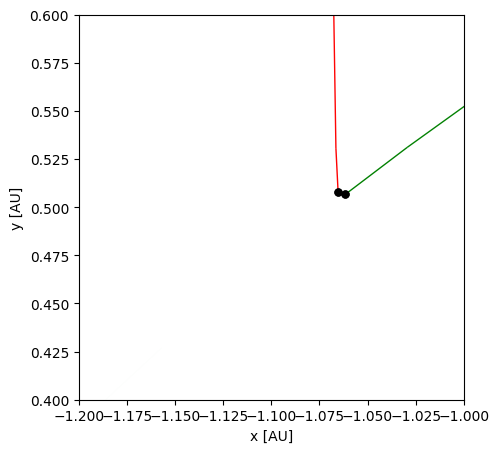

In [94]:
sim = setupSimulation()
sim.integrate(976.7685)
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True, ylim =[0.4,0.6], xlim=[-1.2,-1])
print(f'Eccentricity of Orbit 1: {sim.calculate_orbits()[0].e}')
print(f'True Anomaly of Orbit 1: {sim.calculate_orbits()[0].f}')
print(f'Argument of Peripasis of Orbit 1: {sim.calculate_orbits()[0].omega}')
print(f'SMA of Orbit 1: {215.032*sim.calculate_orbits()[0].a}')
print(f'Eccentricity of Orbit 2: {sim.calculate_orbits()[1].e}')
print(f'True Anomaly of Orbit 2: {sim.calculate_orbits()[1].f}')
print(f'Argument of Peripasis of Orbit 2: {sim.calculate_orbits()[1].omega}')
print(f'SMA of Orbit 2: {215.032*sim.calculate_orbits()[1].a}')